In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.frameon'] = False
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['legend.framealpha'] = 0
plt.rcParams['figure.dpi'] = 200

warnings.filterwarnings('ignore')

For the revised figures, we simply want to extract the myosin and cadherin profile and also integrate the germband length over the predicted velocity fields.

The germband integration is done using a script provided by my brilliant coauthor Nikolas Claussen

In [2]:
from scipy.integrate import solve_ivp
from scipy.interpolate import RectBivariateSpline

def advect(u, x, y, t, t_span, t_eval=None, initial_conds=None, interp_kwargs=None, solver_kwargs=None):
    """
    Advect points (initial conditions) by flow field.

    Seeds streamlines at arbitrary initial conditions,
    specified by the initial_conds array. Can deal with
    both time-dependent and independent velocity fields.
    
    Parameters
    ----------
    u : ndarray of shape (n_timepoints, n_rows, n_cols, 2)
        Vector field values at grid points. u[:,:,:,0] is the x-component,
        u[:,:,:,1] the y-component. If u is a 3d array (len(u.shape) == 3),
        the vector field is assumed to be constant in time.
    x : ndarray of shape (n_cols,)
        Array of x-coordinate values. x[i] == x-coord for u[:,:,i].
        Coordinates must be strictly ascending.
    y : ndarray (n_rows,)
        Array of y-coordinate values. y[i] == y-coord for u[:,i,:].
        Coordinates must be strictly ascending.
    t : ndarry of shape (n_timepoints,)
        Array of times at which vector field is sampled, in strictly
        ascending order.  If the vector field is time independent
        (len(u.shape) == 3), this argument is ignored (just pass None).
    t_span : 2-tuple of floats
        Interval of integration (t0, tf).
    t_eval : np.array, otional.
        Times at which to evaluate the flow. Defaults to
        np.arange(t_span[0], t_span[1]+1), so phi[0] == initial conditions.
    initial_conds : ndarrray of dimension (N, 2)
        Array of initial conditions
    interp_kwargs  : dict, optional
        Parameters for the scipy.interpolate.RectBivariateSpline interpolator,
        see scipy docs. In particular, one can choose the order
        (linear, cubic, ...) and the smoothing paramter.
    solver_kwargs : dict, optional
        Parameters for the scipy ODE solver solve_ivp, see scipy docs.
        The default is {'method'='LSODA', 'rtol'=1e-05}.

    Returns
    -------
    phi : ndarray of shape (#timepoints, n_rows, n_cols, 2)
        Flow of vector field. phi[:,i,j,:] is the trajectory of
        point y[i], y[j], with phi[:,i,j,0] being the x-coordinate
        and phi[:,i,j,1] the y-coordinate. If dense_output is True, return
        array (n_rows, n_cols, 2) of OdeSolution objects.

    """
    ## preliminary argument parsing
    # ensure correct dtype - if coords are ints, errors can occur
    x = x.astype(float, copy=False)
    y = y.astype(float, copy=False)
    initial_conds = initial_conds.astype(float, copy=False)
    if t_eval is None:
        t_eval = np.arange(t_span[0], t_span[1]+1)
    if interp_kwargs is None:
        interp_kwargs = {}
    if solver_kwargs is None:
        solver_kwargs = {'method': 'RK45', 'rtol': 1e-05}
    solver_kwargs['t_eval'] = t_eval
    solver_kwargs['vectorized'] = True

    ## set up interpolator
    if len(u.shape) == 3:  # time-independent vector field
        interp_x = RectBivariateSpline(y, x, u[:, :, 0], **interp_kwargs)
        interp_y = RectBivariateSpline(y, x, u[:, :, 1], **interp_kwargs)

        def rhs(tpt, pts):
            return np.stack([interp_x(pts[1], pts[0]),
                             interp_y(pts[1], pts[0])])
    elif len(u.shape) == 4:
        # RectBivariateSpline can only deal with 2d interpolation.
        # Use a different interpolator for each time point,
        # then interpolate linearly in time between those functions.
        interp_x = [RectBivariateSpline(y, x, vf[:, :, 0], **interp_kwargs)
                    for vf in u]
        interp_y = [RectBivariateSpline(y, x, vf[:, :, 1], **interp_kwargs)
                    for vf in u]
        max_i = len(t)-1

        def rhs(tpt, pts):
            i = np.searchsorted(t, tpt, side='right')
            i = i if i < max_i else max_i
            delta = t[i] - t[i-1]
            val_a = np.stack([interp_x[i-1](pts[1], pts[0]),
                              interp_y[i-1](pts[1], pts[0])])
            val_b = np.stack([interp_x[i](  pts[1], pts[0]),
                              interp_y[i](  pts[1], pts[0])])
            return ((t[i]-tpt)*val_a + (tpt - t[i-1])*val_b)/delta

    ## iterate over initial conditions.
    phi = []
    for x_0 in initial_conds:
        out = solve_ivp(rhs, t_span, x_0, **solver_kwargs)
        assert out['status'] != -1, "integration failed"
        phi.append(out['y'])
        
    return np.stack(phi).transpose(2,0,1)

608.3 1022.4000000000001 3.23 455.701
205.0 512.5 3.227 536.891


Text(0.5, 1.0, 'Units of microns')

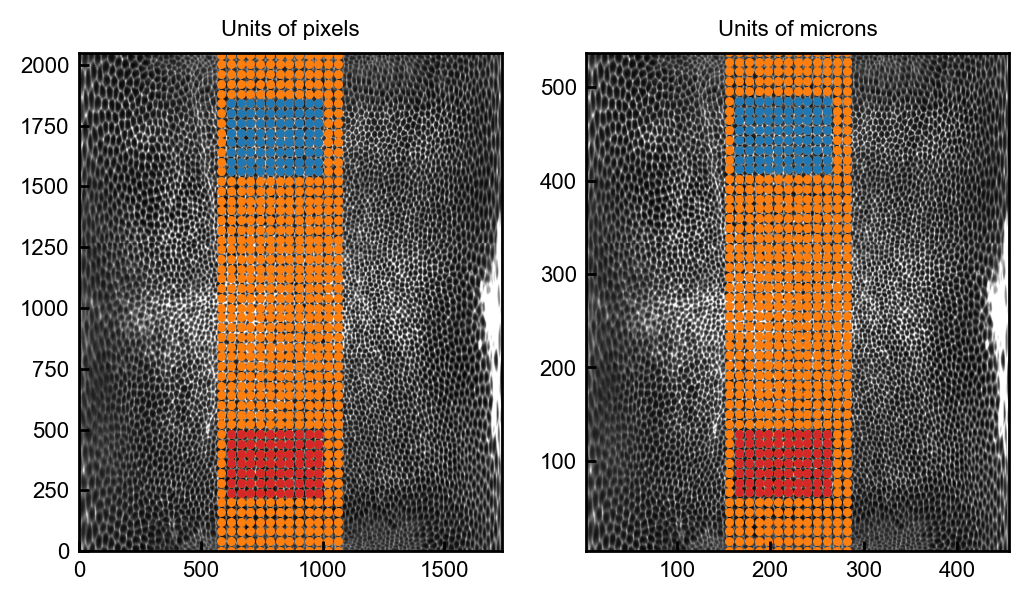

In [4]:
## load movie
from skimage import io
from morphogenesis.plot_utils import dv_min, dv_max, ap_min, ap_max 
root_path = "../flydrive/nikolas_data/tissue flow integration/data"
movie_CAAX = io.imread(f"{root_path}/MAX_Cyl1_2_000000_c1_rot_scaled_view1_every_frame.tif")


# select initial conditions
initial = np.stack(np.meshgrid(np.arange(583.0, 1079.0, 40),
                               np.arange(501.0, 2565.0, 40)), axis=-1)

initial_shape = initial.shape[:2]

initial = initial.reshape((np.prod(initial.shape[:2]),2))
pad_width = 500

# Get germ band mask from initial conditions
# select region of embryo considered the "germ band" - this avoids regions which move across the posterior pole.
# in percentage of embryo length and half circumference
ap_initial = initial[:,0]
dv_initial = initial[:,1]-pad_width

cut_a = 0.35*1738# * pixel_size + ap_min
cut_p = 0.8*1278# * pixel_size + ap_min
cut_ventral = 0.2*1025# * pixel_size + dv_min
cut_dorsal = 0.5*1025# * pixel_size + dv_min

print(cut_a, cut_p, ap_min, ap_max)
print(cut_ventral, cut_dorsal, dv_min, dv_max)

mask_ap = (ap_initial>cut_a) & (ap_initial<cut_p) 

mask_top = (dv_initial>cut_ventral) & (dv_initial<cut_dorsal) & mask_ap
mask_bottom = (dv_initial<(2050-cut_ventral)) & (dv_initial>(2050-cut_dorsal)) & mask_ap

# Plot everything to see if it makes sense
fig, ax = plt.subplots(1,2,figsize=(6,6))

ax[0].imshow(movie_CAAX[50], cmap='gray', origin='lower')
ax[0].scatter(initial[:,0], initial[:,1]-pad_width, s=5, c="tab:orange")
ax[0].scatter(initial[mask_top,0], initial[mask_top,1]-pad_width, s=5, c="tab:red")
ax[0].scatter(initial[mask_bottom,0], initial[mask_bottom,1]-pad_width, s=5, c="tab:blue")
ax[0].set_title('Units of pixels')

# Add the pixel size conversions from Nikolas' notebook
pixel_size = 0.2619 # microns / pixel
initial[:, 0] = initial[:, 0] * pixel_size + ap_min
initial[:, 1] = initial[:, 1] * pixel_size + dv_min
pad_width = pad_width * pixel_size

initial[:, 1] = initial[:, 1] - pad_width

ax[1].imshow(movie_CAAX[50], cmap='gray', extent=[ap_min, ap_max, dv_min, dv_max], origin='lower')
ax[1].scatter(initial[:,0], initial[:, 1], s=5, c="tab:orange")
ax[1].scatter(initial[mask_top,0], initial[mask_top,1], s=5, c="tab:red")
ax[1].scatter(initial[mask_bottom,0], initial[mask_bottom,1], s=5, c="tab:blue")
ax[1].set(xlim=[ap_min, ap_max], ylim=[dv_min, dv_max])
ax[1].set_title('Units of microns')

2.27
2.27 57
3.23 455.701 3.23 454.96000000000004
3.227 536.891 -126.16300000000001 666.067
(350, 200) (350, 200) (21, 350, 200, 2)


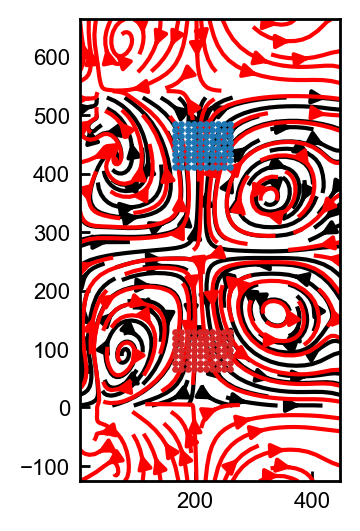

In [5]:
def preprocess_velocity(v, dd=2.27, pad_points=57):
    # I use y,x ordering instead of x,y ordering on the channel axis
    v = v[:, ::-1].transpose(0, 2, 3, 1)
    vv = np.pad(v, ((0, 0), (pad_points, pad_points), (0,0), (0,0)), mode='wrap')
    yy, xx = np.meshgrid(
        np.arange(vv.shape[1]) * dd + dv_min,
        np.arange(vv.shape[2]) * dd + ap_min,
        indexing='ij'
    )
    pad_width = pad_points * dd
    yy -= pad_width
    return vv, (yy, xx)

wt = np.load('predictions/WTComparison.npz')
v = wt['v0']
y, x = np.meshgrid(
    np.linspace(dv_min, dv_max, v.shape[-2]),
    np.linspace(ap_min, ap_max, v.shape[-1]),
    indexing='ij'
)

dd = np.round(y[1,1]-y[0,0], 2)
print(dd)
pad_points = int(pad_width // dd)
print(dd, pad_points)

vv, (yy, xx) = preprocess_velocity(v, dd=dd, pad_points=pad_points)

print(x.min(), x.max(), xx.min(), xx.max())
print(y.min(), y.max(), yy.min(), yy.max())
print(xx.shape, yy.shape, vv.shape)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
skip = 4
ax.streamplot(x[::skip, ::skip], y[::skip, ::skip],
              v[-1, 1, ::skip, ::skip], v[-1, 0, ::skip, ::skip], color='k')
ax.streamplot(xx[::skip, ::skip], yy[::skip, ::skip],
              vv[-1, ::skip, ::skip, 0], vv[-1, ::skip, ::skip, 1], color='r')


ax.scatter(initial[mask_top,0], initial[mask_top,1], s=2, c="tab:red", zorder=10)
ax.scatter(initial[mask_bottom,0], initial[mask_bottom,1], s=2, c="tab:blue", zorder=10)
ax.set_aspect('equal')


In [6]:
# Run integration
phi = advect(
    u=vv, 
    x=xx[0,:], 
    y=yy[:,0], 
    t=np.arange(vv.shape[0]-1), 
    t_span=(0, vv.shape[0]-1),
    initial_conds=initial,
)

phi_germ_top = phi[:,mask_top,:]
phi_germ_bottom = phi[:,mask_bottom,:]


(3.23, 455.701, 3.227, 536.891)

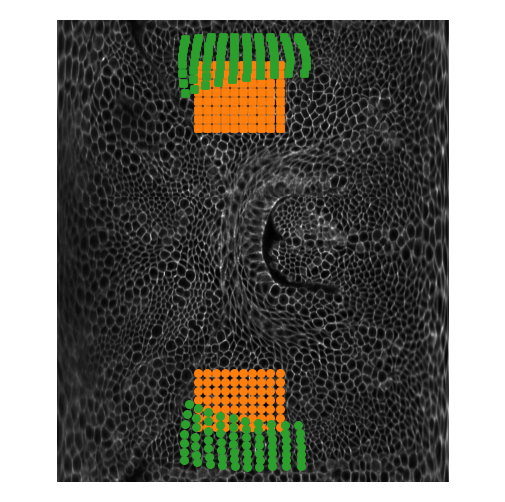

In [7]:
# plot trajectories

t  = 190

fig = plt.figure(figsize=(3, 3))
plt.imshow(movie_CAAX[t], cmap="gray", extent=[ap_min, ap_max, dv_min, dv_max], origin="lower")
 
plt.scatter(phi_germ_top[0][:,0], phi_germ_top[0][:,1], c="tab:orange", s=5, marker="o")
plt.scatter(phi_germ_top[-1][:,0], phi_germ_top[-1][:,1], c="tab:green", s=5, marker="o")

plt.scatter(phi_germ_bottom[0][:,0], phi_germ_bottom[0][:,1], c="tab:orange", s=5, marker="s")
plt.scatter(phi_germ_bottom[-1][:,0], phi_germ_bottom[-1][:,1], c="tab:green", s=5, marker="s")

plt.axis("equal")
plt.axis("off")

Text(0, 0.5, 'Extension [%]')

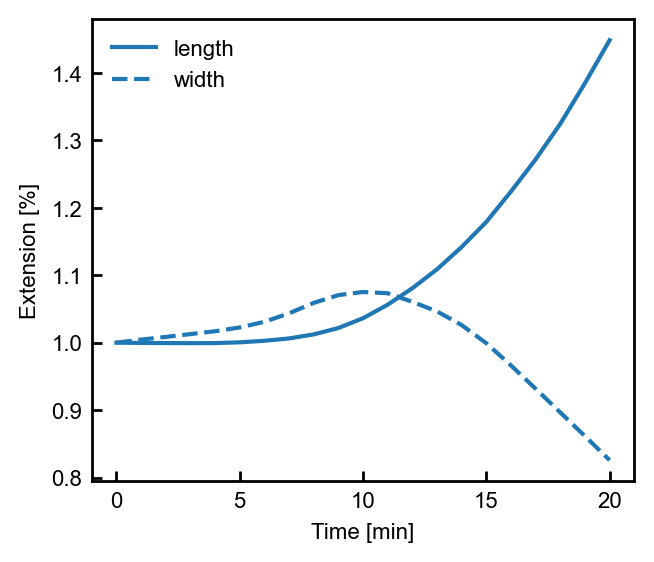

In [8]:
length_top = np.quantile(phi_germ_top[:,:,0], 0.95, axis=1)-np.quantile(phi_germ_top[:,:,0], 0.05, axis=1)
length_top = length_top/length_top[0]

length_bottom = np.quantile(phi_germ_bottom[:,:,0], 0.95, axis=1)-np.quantile(phi_germ_bottom[:,:,0], 0.05, axis=1)
length_bottom = length_bottom/length_bottom[0]

length = (length_top+length_bottom)/2

width_top = np.quantile(phi_germ_top[:,:,1], 0.95, axis=1)-np.quantile(phi_germ_top[:,:,1], 0.05, axis=1)
width_top = width_top/width_top[0]

width_bottom = np.quantile(phi_germ_bottom[:,:,1], 0.95, axis=1)-np.quantile(phi_germ_bottom[:,:,1], 0.05, axis=1)
width_bottom = width_bottom/width_bottom[0]

width = (width_top+width_bottom)/2

fig = plt.figure(figsize=(3.5, 3))

time = np.arange(length.shape[0])
plt.plot(time, length, label="length", color="tab:blue")
plt.plot(time, width, label="width",ls="dashed", color="tab:blue")

plt.legend()
plt.xlabel("Time [min]")
plt.ylabel("Extension [%]")
#plt.yticks([50, 100, 150, 200]);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


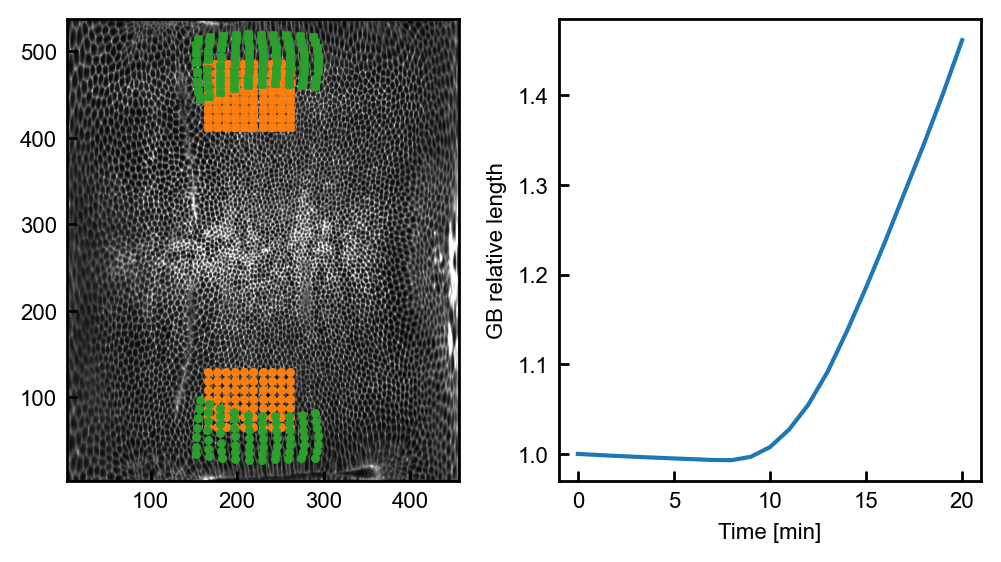

In [9]:
def advect_and_get_germband_extension(v, plot=False):
    vv, (yy, xx) = preprocess_velocity(v, dd=dd, pad_points=pad_points)
    time = np.arange(vv.shape[0])
    phi = advect(
        u=vv, 
        x=xx[0,:], 
        y=yy[:,0], 
        t=time,
        t_span=(0, time[-1]),
        initial_conds=initial,
    )
    phi_germ_top = phi[:,mask_top,:]
    phi_germ_bottom = phi[:,mask_bottom,:]

    length_top = np.quantile(phi_germ_top[:,:,0], 0.95, axis=1)-np.quantile(phi_germ_top[:,:,0], 0.05, axis=1)
    length_top = length_top/length_top[0]

    length_bottom = np.quantile(phi_germ_bottom[:,:,0], 0.95, axis=1)-np.quantile(phi_germ_bottom[:,:,0], 0.05, axis=1)
    length_bottom = length_bottom/length_bottom[0]

    length = (length_top+length_bottom)/2

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(6,3))
        ax[0].imshow(movie_CAAX[80], cmap="gray", extent=[ap_min, ap_max, dv_min, dv_max], origin="lower")
        ax[0].scatter(phi_germ_top[0][:,0], phi_germ_top[0][:,1], c="tab:orange", s=5, marker="o")
        ax[0].scatter(phi_germ_top[-1][:,0], phi_germ_top[-1][:,1], c="tab:green", s=5, marker="o")

        ax[0].scatter(phi_germ_bottom[0][:,0], phi_germ_bottom[0][:,1], c="tab:orange", s=5, marker="s")
        ax[0].scatter(phi_germ_bottom[-1][:,0], phi_germ_bottom[-1][:,1], c="tab:green", s=5, marker="s")
        ax[0].set_aspect('equal')

        ax[1].plot(time, length, color="tab:blue")
        ax[1].legend()
        ax[1].set(
            xlabel='Time [min]',
            ylabel='GB relative length',
        )

    return time, length

advect_and_get_germband_extension(wt['v'], plot=True);
    

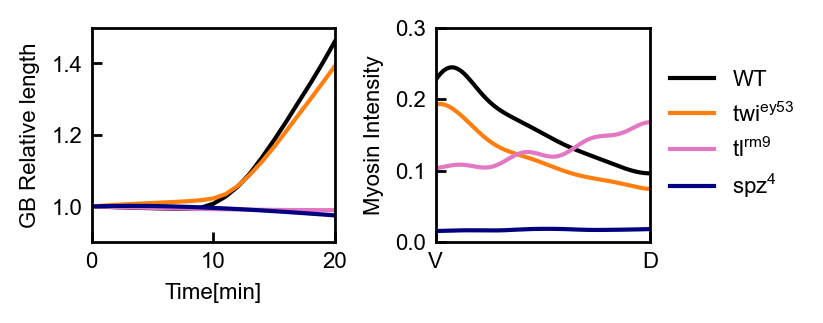

In [10]:
# Load data
twist = np.load('predictions/TwistMutants.npz')
toll = np.load('predictions/TollMutants.npz')
spz = np.load('predictions/SpzMutants.npz')
wt = np.load('predictions/WTComparison.npz')

# Plotting functions
from morphogenesis.plot_utils import plot_tensor, ap_min, ap_max, dv_min, dv_max, dv_midpoint
from scipy.interpolate import RectBivariateSpline as interp2d
from scipy.stats import sem
from math import floor, ceil
def get_velocity(v, tt, X0, Y0, x, y):
    idxA, idxB = floor(tt), ceil(tt)
    frac = 1 - (tt - idxA)
    vA, vB = v[idxA], v[idxB]
        
    vx = interp2d(Y0, X0, frac * vA[1] + (1 - frac) * vB[1])(y, x, grid=False)
    vy = interp2d(Y0, X0, frac * vA[0] + (1 - frac) * vB[0])(y, x, grid=False)
    return vx, vy

def get_cut(z, N0=50, N1=150):
    '''
    Return the average DV cut between N0 and N1 along the AP axis
    '''
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
    cut = np.mean(znorm[:, N0:N1], axis=1)
    cst = np.std(znorm[:, N0:N1], axis=1)

    return cut, cst

    # Normalize by value at Ventral pole
    return cut / cut[118]

dv = np.linspace(dv_min, dv_max, 236)


fig, ax = plt.subplots(1, 2, figsize=(4.0, 1.5), constrained_layout=True)

colors = ['black', 'tab:orange', 'tab:pink', 'navy']
labels = ['WT', r'twi$^{\mathregular{ey53}}$', r'tl$^{\mathregular{rm9}}$', r'spz$^{\mathregular{4}}$']
datasets = [wt, twist, toll, spz]
for data, color, label in zip(datasets, colors, labels):
    # Germband relative length
    time, length = advect_and_get_germband_extension(data['v'])
    ax[0].plot(time, length, label=label, color=color)

    # Myosin anisotropy profile
    cut1, std1 = get_cut(data['m'][-1])
    ax[1].plot(dv, cut1, label=label, color=color)
    #ax[1].fill_between(dv, cut1-std1, cut1+std1, color=color, alpha=0.2)

# Axis formatting
vfc = 40 # Crop ventral region
ax[0].set(
    xlabel='Time[min]', xlim=[0, 20], xticks=[0, 10, 20],
    ylabel='GB Relative length', ylim=[0.9, 1.5], yticks=[1, 1.2, 1.4],
)
ax[1].set(
    xlim=[dv_min+vfc, dv_midpoint], xticks=[dv_min+vfc, dv_midpoint], xticklabels=['V', 'D'],
    ylim=[0, 0.3], yticks=[0, 0.1, 0.2, 0.3], ylabel='Myosin Intensity',
    aspect=(dv_midpoint-dv_min-vfc) / 0.3,
)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('figures/gb_extension_myosin_anisotropy.svg', bbox_inches='tight')

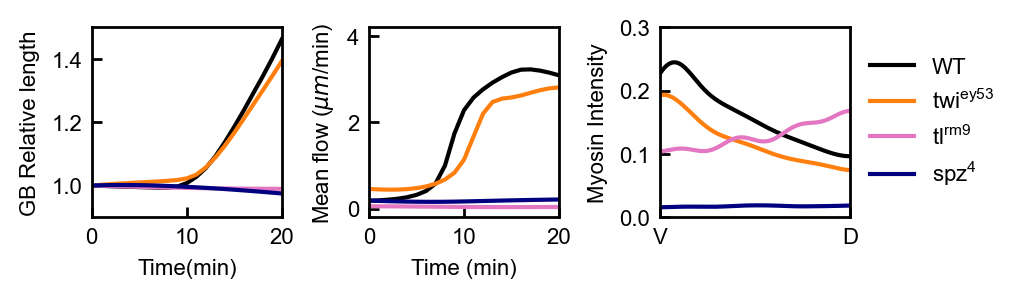

In [19]:
# Load data
twist = np.load('predictions/TwistMutants.npz')
toll = np.load('predictions/TollMutants.npz')
spz = np.load('predictions/SpzMutants.npz')
wt = np.load('predictions/WTComparison.npz')

# Plotting functions
from morphogenesis.plot_utils import plot_tensor, ap_min, ap_max, dv_min, dv_max, dv_midpoint
from scipy.interpolate import RectBivariateSpline as interp2d
from scipy.stats import sem
from math import floor, ceil
def get_velocity(v, tt, X0, Y0, x, y):
    idxA, idxB = floor(tt), ceil(tt)
    frac = 1 - (tt - idxA)
    vA, vB = v[idxA], v[idxB]
        
    vx = interp2d(Y0, X0, frac * vA[1] + (1 - frac) * vB[1])(y, x, grid=False)
    vy = interp2d(Y0, X0, frac * vA[0] + (1 - frac) * vB[0])(y, x, grid=False)
    return vx, vy

def get_cut(z, N0=50, N1=150):
    '''
    Return the average DV cut between N0 and N1 along the AP axis
    '''
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
    cut = np.mean(znorm[:, N0:N1], axis=1)
    cst = np.std(znorm[:, N0:N1], axis=1)

    return cut, cst

    # Normalize by value at Ventral pole
    return cut / cut[118]

dv = np.linspace(dv_min, dv_max, 236)


fig, ax = plt.subplots(1, 3, figsize=(5.0, 1.5), constrained_layout=True)

colors = ['black', 'tab:orange', 'tab:pink', 'navy']
labels = ['WT', r'twi$^{\mathregular{ey53}}$', r'tl$^{\mathregular{rm9}}$', r'spz$^{\mathregular{4}}$']
datasets = [wt, twist, toll, spz]
for data, color, label in zip(datasets, colors, labels):
    # Germband relative length
    time, length = advect_and_get_germband_extension(data['v'])
    ax[0].plot(time, length, label=label, color=color)

    # Velocity strength
    vnorm = np.linalg.norm(data['v'], axis=1).mean(axis=(1,2))
    v0norm = np.linalg.norm(data['v0'], axis=1).mean(axis=(1,2))
    #ax[1].plot(data['t'], v0norm, label='Exp', color=color, linestyle='--')
    ax[1].plot(data['t'], vnorm, label='ML', color=color)

    # Myosin anisotropy profile
    #cut0, std0 = get_cut(data['m0'][-1])
    #ax[2].plot(dv, cut0, linestyle='--', color=color)
    cut1, std1 = get_cut(data['m'][-1])
    ax[2].plot(dv, cut1, label=label, color=color)
    #ax[1].fill_between(dv, cut1-std1, cut1+std1, color=color, alpha=0.2)

# Axis formatting
vfc = 40 # Crop ventral region
ax[0].set(
    xlabel='Time(min)', xlim=[0, 20], xticks=[0, 10, 20],
    ylabel='GB Relative length', ylim=[0.9, 1.5], yticks=[1, 1.2, 1.4],
    aspect=20/0.6
)
ax[1].set(
    xlim=[0, 20], xticks=[0, 10, 20], xlabel='Time (min)',
    ylim=[-0.2, 4.2], yticks=[0, 2, 4], ylabel='Mean flow ($\\mu m$/min)',
    aspect=20/4.4,
)
ax[2].set(
    xlim=[dv_min+vfc, dv_midpoint], xticks=[dv_min+vfc, dv_midpoint], xticklabels=['V', 'D'],
    ylim=[0, 0.3], yticks=[0, 0.1, 0.2, 0.3], ylabel='Myosin Intensity',
    aspect=(dv_midpoint-dv_min-vfc) / 0.3,
)
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('figures/gb_extension_myosin_anisotropy.svg', bbox_inches='tight')